In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

# Loading and Preparing the Data

In [2]:
mi_h=pd.read_csv("DEMsExpression.csv")
cad=pd.read_csv("MI-Healthy DEMs Expression of CAD samples.csv")
df=pd.concat([mi_h, cad], axis=0)

target = []
for sample in df['Unnamed: 0']:
    if sample[-1] == "H":
        target.append("Healthy")
    elif sample[-1] == "M":
        target.append("MI")
    elif sample[-1] == "C":
        target.append("CAD")

df["MI status"] = target
df.drop('Unnamed: 0', axis=1, inplace = True)

In [3]:
df.head()

,7900488 / MIR30E,7923976 / C1orf132///MIR29B2,7971661 / MIR15A,7976832 / MIR323A,8008885 / MIR21,8045453 / MIR128-1,8084755 / MIR28,8087881 / MIRLET7G,8163107 / MIR32,8175248 / MIR92A2,MI status
0,5.86237,4.17884,5.93182,3.31011,8.79683,4.71189,3.45519,7.52580,6.67709,3.16477,Healthy
1,5.61056,3.90262,6.09685,3.54984,9.09161,4.82916,3.52235,7.55883,6.60037,3.14140,Healthy
2,6.47634,4.42823,6.45591,3.78296,9.46479,4.56398,3.64562,7.69815,6.91699,3.05517,Healthy
3,6.29086,4.16566,6.38480,3.47636,9.16028,4.41579,3.72838,7.59828,6.30052,3.05037,Healthy
4,5.42813,3.83066,6.30655,3.82938,8.31414,4.49369,3.53013,7.36374,6.18958,2.99243,Healthy


In [4]:
df.shape

(250, 11)

# Exploratory Data Analysis

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
7900488 / MIR30E,250.0,7.450548,0.607236,5.356128,7.199537,7.633360,7.867915,8.360230
7923976 / C1orf132///MIR29B2,250.0,5.384517,0.655981,3.628750,5.232723,5.600820,5.820860,6.509030
7971661 / MIR15A,250.0,6.990930,0.600481,5.072702,6.717252,7.124750,7.360918,8.311290
7976832 / MIR323A,250.0,3.548375,0.548304,2.870420,3.200370,3.345095,3.610920,5.171396
8008885 / MIR21,250.0,10.115399,0.952993,6.982273,9.503113,10.320200,10.771200,12.349500
8045453 / MIR128-1,250.0,5.643931,0.556826,4.081839,5.548987,5.816710,6.024390,6.386390
8084755 / MIR28,250.0,5.181250,0.812016,3.365152,5.001390,5.478615,5.723738,6.492950
8087881 / MIRLET7G,250.0,7.821840,0.667161,5.664453,7.559920,7.975815,8.265690,9.254780
8163107 / MIR32,250.0,7.565765,0.821758,4.744559,7.351542,7.817910,8.111895,8.957920
8175248 / MIR92A2,250.0,2.938011,0.435897,2.463260,2.647992,2.757300,2.960275,4.055258


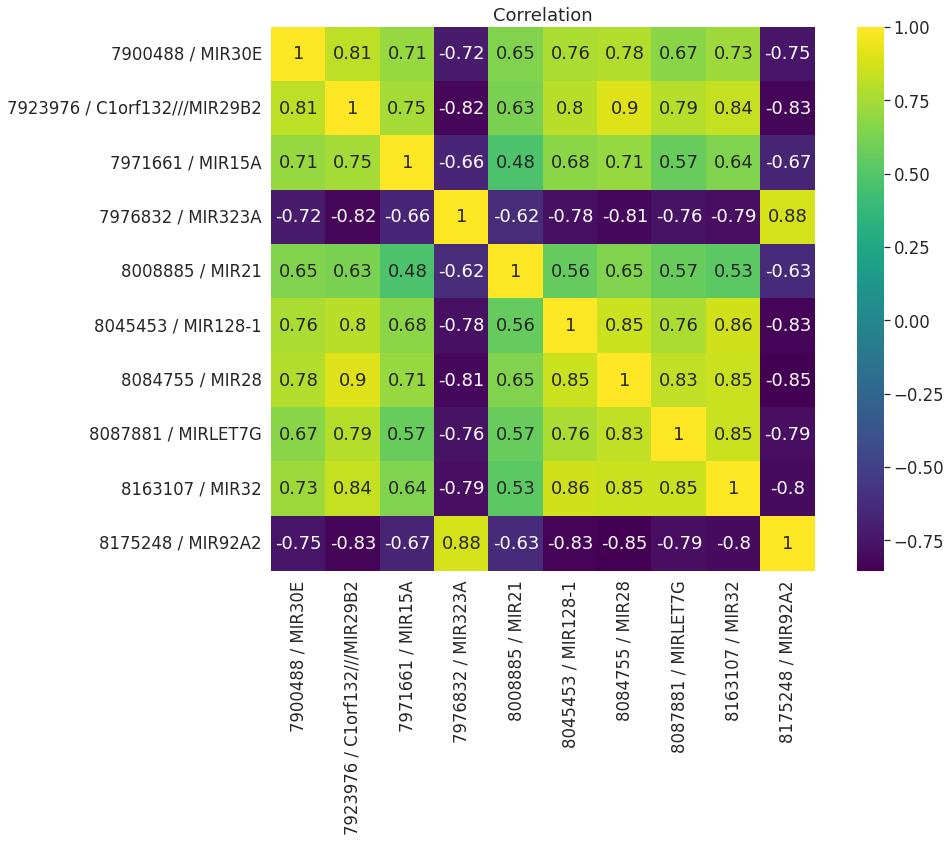

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.heatmap(df.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation')
plt.show()
plt.savefig('corrforall.pdf', bbox_inches='tight')

In [10]:
df_melt=pd.melt(df, id_vars='MI status')

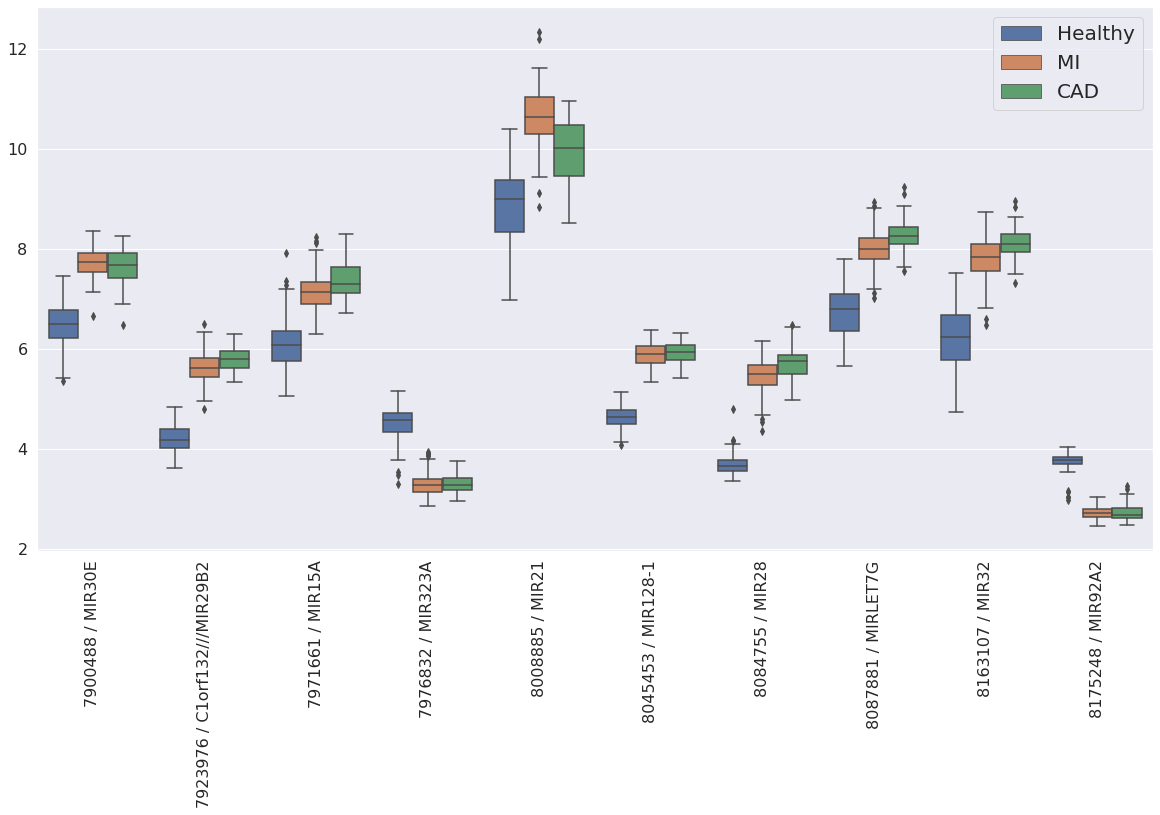

In [11]:
plt.figure(figsize=(20,10))
sns.boxplot(x="variable", y="value", hue='MI status', data=df_melt);
plt.ylabel('', fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.legend(loc='upper right', prop={'size':20})
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Expressionforall.pdf', bbox_inches='tight')

In [12]:
corr = df.corr()
corr = corr[corr < 1]
corr = corr[corr > -1]
corr[corr >= 0.8].sum()+abs(corr[corr <= -0.8].sum())

7900488 / MIR30E                0.814259
7923976 / C1orf132///MIR29B2    5.002301
7971661 / MIR15A                0.000000
7976832 / MIR323A               2.514856
8008885 / MIR21                 0.000000
8045453 / MIR128-1              3.347095
8084755 / MIR28                 5.097673
8087881 / MIRLET7G              1.678399
8163107 / MIR32                 3.405436
8175248 / MIR92A2               3.394481
dtype: float64

4 microRNA with the highest cprrelation with others have been deleted. By delitation of these miRs, there is no miRs with correlation coefitient more than 0.8 or less than -0.8.

In [13]:
df_new=df.drop(['7923976 / C1orf132///MIR29B2', '8084755 / MIR28', '8163107 / MIR32', '8175248 / MIR92A2'], axis=1)
df_new=df_new.reindex()

In [14]:
corr = df_new.corr()
corr = corr[corr < 1]
corr = corr[corr > -1]
corr[corr >= 0.8].sum()+abs(corr[corr <= -0.8].sum())

7900488 / MIR30E      0.0
7971661 / MIR15A      0.0
7976832 / MIR323A     0.0
8008885 / MIR21       0.0
8045453 / MIR128-1    0.0
8087881 / MIRLET7G    0.0
dtype: float64

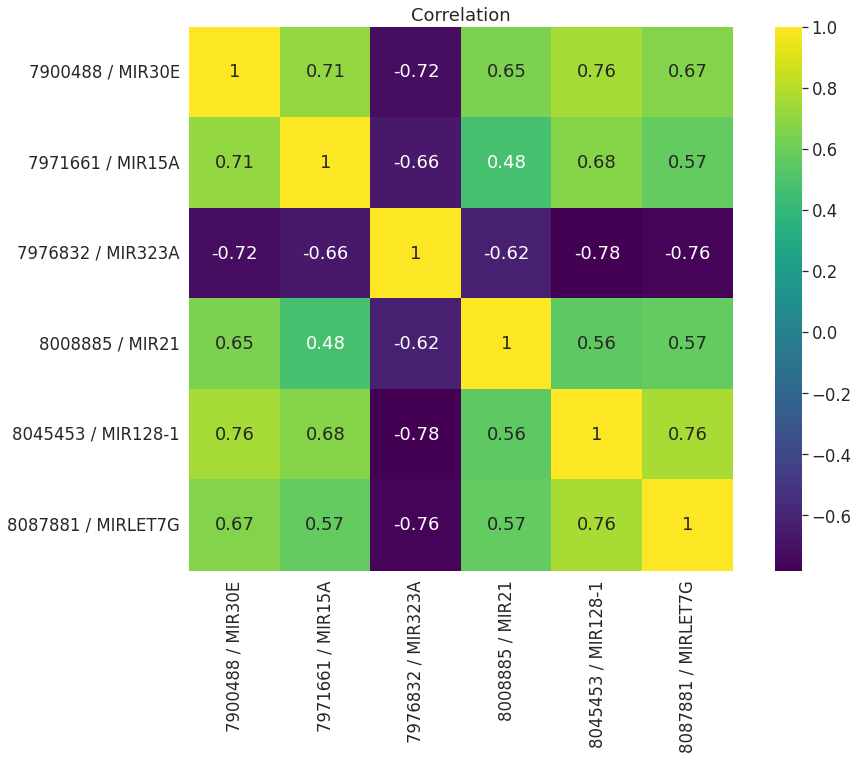

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.heatmap(df_new.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation')
plt.show()
plt.savefig('corrfor6.pdf', bbox_inches='tight')

In [16]:
df_melt=pd.melt(df_new, id_vars='MI status')

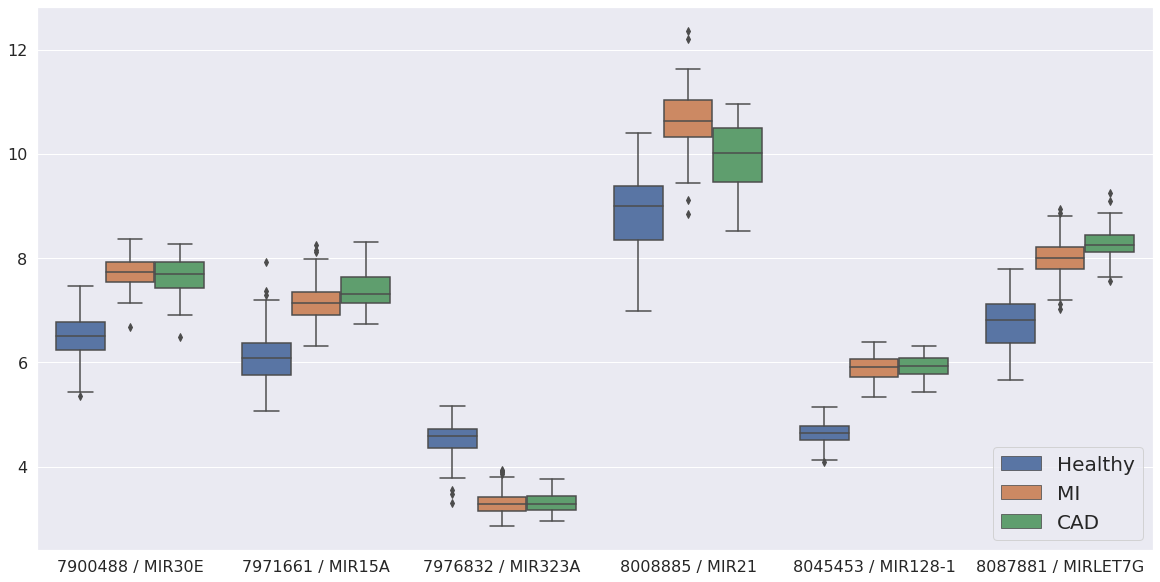

In [17]:
plt.figure(figsize=(20,10))
sns.boxplot(x="variable", y="value", hue='MI status', data=df_melt);
plt.ylabel('', fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.legend(loc='lower right', prop={'size':20})
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Expressionfor6.pdf', bbox_inches='tight')

## Adding a target columns for further use

In [132]:
df_new['H or M/C']=df_new['MI status']
df_new['H or M/C'][df_new['H or M/C'] != 'Healthy'] = 'Not_Healthy'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Healthy or MI/CAD

In [137]:
scoring = ['precision_weighted', 'accuracy']

In [138]:
mirs=list(df_new.columns)[0:5]
result=[]
for mir in mirs:
  X_temp=pd.DataFrame(df_new[mir])
  y_temp = df_new['H or M/C']
  cv=StratifiedKFold(n_splits=10)
  svm=SVC(kernel='linear', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=cv,
                          n_jobs=-1, return_train_score=True)
  scores=pd.DataFrame(scores)
  result.append([mir, list(scores.mean(axis=0))])

In [139]:
result

[['7900488 / MIR30E',
  [0.005127668380737305,
   0.003980326652526856,
   0.9466103896103896,
   0.9473745210388284,
   0.9440000000000002,
   0.9480000000000001]],
 ['7971661 / MIR15A',
  [0.006173563003540039,
   0.004236531257629394,
   0.9445089542036911,
   0.9520049976637106,
   0.9440000000000002,
   0.952]],
 ['7976832 / MIR323A',
  [0.005348467826843261,
   0.0043955564498901365,
   0.9841666666666666,
   0.9796831448792054,
   0.9800000000000001,
   0.979111111111111]],
 ['8008885 / MIR21',
  [0.004762840270996094,
   0.0048506736755371095,
   0.8832087960348829,
   0.878586562012765,
   0.852,
   0.8844444444444444]],
 ['8045453 / MIR128-1',
  [0.004088544845581054, 0.005032467842102051, 1.0, 1.0, 1.0, 1.0]]]

The best candidates are mir-128-1 with all 1.0 scores and mir-323a with scores near 0.98. It should be mentioned that the data is highly imbalanced.

In [ ]:
cross_val_predict

# MI/CAD

In [149]:
df_mc=df_new[df_new['MI status'] != 'Healthy']
X=df_mc.drop(['MI status', 'H or M/C'], axis=1)
y=df_mc['MI status']

In [151]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [153]:
X=pd.concat([X_train,y_train],axis=1)
X['MI status'].value_counts()

MI     97
CAD    42
Name: MI status, dtype: int64

## Resampling for handling imbalanced data

In [169]:
MI=X[X['MI status'] == 'MI']
CAD=X[X['MI status'] == 'CAD']

In [178]:
#less_MI=resample(MI, replace=False, n_samples=90, random_state=4)
more_CAD=resample(CAD,replace=True, n_samples=97, random_state=1)

df_resample=pd.concat([more_CAD,MI])

In [179]:
df_resample['MI status'].value_counts()

CAD    97
MI     97
Name: MI status, dtype: int64

## Training all possible combinations with 3 miRs

In [192]:
mirs=list(df_resample.columns)[0:6]
listOf3Combinations=[]
for i in range(len(mirs)):
  for j in range(i+1,len(mirs)):
    for k in range(j+1,len(mirs)):
      listOf3Combinations.append([mirs[i], mirs[j], mirs[k]])

len(listOf3Combinations)

20

In [193]:
#defining scoring for all furthur uses in cross validation
scoring = ['precision_weighted', 'accuracy']

In [194]:
result3=[]
for i in range(len(listOf3Combinations)):
  X_temp = df_resample[listOf3Combinations[i]]
  y_temp = df_resample['MI status']
  svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=10,
                          n_jobs=-1, return_train_score=True)
  scores=pd.DataFrame(scores)
  result3.append([listOf3Combinations[i], list(scores.mean(axis=0))])

In [195]:
result3

[[['7900488 / MIR30E', '7971661 / MIR15A', '7976832 / MIR323A'],
  [0.011251044273376466,
   0.004799008369445801,
   0.7440833727675833,
   0.7714697625257865,
   0.7207894736842106,
   0.7594351395730705]],
 [['7900488 / MIR30E', '7971661 / MIR15A', '8008885 / MIR21'],
  [0.01045243740081787,
   0.005459189414978027,
   0.8157646008961799,
   0.8256054187936895,
   0.79,
   0.8219014778325124]],
 [['7900488 / MIR30E', '7971661 / MIR15A', '8045453 / MIR128-1'],
  [0.008855652809143067,
   0.004190921783447266,
   0.7312239660923872,
   0.7449254596570356,
   0.7107894736842104,
   0.732518883415435]],
 [['7900488 / MIR30E', '7971661 / MIR15A', '8087881 / MIRLET7G'],
  [0.008761096000671386,
   0.004410433769226074,
   0.8276787978103768,
   0.8388967191668149,
   0.7981578947368421,
   0.8224367816091954]],
 [['7900488 / MIR30E', '7976832 / MIR323A', '8008885 / MIR21'],
  [0.008860325813293457,
   0.004122090339660644,
   0.7864304993252361,
   0.7904917528610544,
   0.773947368421052

## Training all possible combinations with 4 miRs

In [196]:
mirs=list(df_resample.columns)[0:6]
listOf4Combinations=[]
for i in range(len(mirs)):
  for j in range(i+1,len(mirs)):
    for k in range(j+1,len(mirs)):
      for h in range(k+1,len(mirs)):
        listOf4Combinations.append([mirs[i], mirs[j], mirs[k], mirs[h]])

len(listOf4Combinations)

15

In [197]:
#defining scoring for all furthur uses in cross validation
scoring = ['precision_weighted', 'accuracy']

In [198]:
result4=[]
for i in range(len(listOf4Combinations)):
  X_temp = df_resample[listOf4Combinations[i]]
  y_temp = df_resample['MI status']
  svm=SVC(C=1000, gamma=0.05, kernel='rbf', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=10,
                          n_jobs=-1, return_train_score=True)
  scores=pd.DataFrame(scores)
  result4.append([listOf4Combinations[i], list(scores.mean(axis=0))])

In [199]:
result4

[[['7900488 / MIR30E',
   '7971661 / MIR15A',
   '7976832 / MIR323A',
   '8008885 / MIR21'],
  [0.009397935867309571,
   0.004411172866821289,
   0.8125366446419078,
   0.8487921239391529,
   0.805,
   0.8482298850574713]],
 [['7900488 / MIR30E',
   '7971661 / MIR15A',
   '7976832 / MIR323A',
   '8045453 / MIR128-1'],
  [0.00951089859008789,
   0.004317951202392578,
   0.7655920103288525,
   0.7716780548867839,
   0.7471052631578947,
   0.762328407224959]],
 [['7900488 / MIR30E',
   '7971661 / MIR15A',
   '7976832 / MIR323A',
   '8087881 / MIRLET7G'],
  [0.01019117832183838,
   0.0040394306182861325,
   0.8343204821494294,
   0.8564183614618063,
   0.8197368421052632,
   0.8505057471264367]],
 [['7900488 / MIR30E',
   '7971661 / MIR15A',
   '8008885 / MIR21',
   '8045453 / MIR128-1'],
  [0.00839405059814453,
   0.004356908798217774,
   0.8203936414462729,
   0.8308681960038566,
   0.8052631578947368,
   0.8299080459770115]],
 [['7900488 / MIR30E',
   '7971661 / MIR15A',
   '8008885 / M

From the model trained for healthy and not_healthy group, we know that mir-128-1 and mir-323a are the best candidates for these two group differentiation. Therefore, finding a combination with one of these mirs included would be great.

## Nested Cross_Validation for the best combinations

In [205]:
best_mirs=['7976832 / MIR323A',
   '8008885 / MIR21',
   '8045453 / MIR128-1',
   '8087881 / MIRLET7G']
X_temp = df_resample[best_mirs]
y_temp = df_resample['MI status']

In [59]:
# configure the cross-validation procedure
cv_inner = KFold(n_splits=10, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=7, shuffle=True, random_state=1)

In [65]:
model = SVC(random_state=1)
param_grid = {
  'C': [100, 500, 1000, 2000,  10000],
  'gamma': [0.01, 0.02, 0.05, 0.07, 0.1],
  'kernel': ['rbf', 'linear', 'sigmoid']
}

In [66]:
search = GridSearchCV(model, param_grid, n_jobs=-1, cv=cv_inner, refit=True)
scores = cross_validate(search, X_temp, y_temp, scoring=scoring, 
                        cv=cv_outer, n_jobs=-1, return_train_score=True, 
                        return_estimator =True)

In [67]:
scores=pd.DataFrame(scores)
scores_mean=list(scores.mean(axis=0))
scores_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


[17.855753626142228,
 0.004675013678414481,
 0.9070572284858,
 0.9347095890657792,
 0.8871366728509587,
 0.9321964977851606]

In [ ]:
scores

,fit_time,score_time,estimator,test_precision_weighted,train_precision_weighted,test_accuracy,train_accuracy
0,16.681303,0.004452,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.892857,0.939216,0.863636,0.937500
1,24.122913,0.003033,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.818182,0.930584,0.818182,0.929688
2,19.211090,0.004181,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.922078,0.923456,0.909091,0.921875
3,19.203104,0.004201,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.863946,0.969436,0.809524,0.968992
4,21.714826,0.002980,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.861039,0.948402,0.857143,0.945736
5,19.984781,0.004294,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.956044,0.932952,0.952381,0.930233
6,13.449389,0.002732,"GridSearchCV(cv=KFold(n_splits=10, random_stat...",0.904762,0.984973,0.904762,0.984496


In [181]:
svm=SVC(C=1100, gamma=0.05, kernel='rbf', random_state=1)
scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=10,
                          n_jobs=-1, return_train_score=True)
scores=pd.DataFrame(scores)

In [182]:
list(scores.mean(axis=0))

[0.011516261100769042,
 0.005226278305053711,
 0.8528528708133972,
 0.8961726177402966,
 0.8339473684210527,
 0.8923218390804598]

In [207]:
X_test

,7976832 / MIR323A,8008885 / MIR21,7971661 / MIR15A,8087881 / MIRLET7G
41,3.27823,9.66554,7.35401,8.57658
46,2.99622,8.95818,7.60849,8.11395
103,3.39042,10.47830,7.18199,8.19352
56,3.32272,9.89816,7.57761,8.68983
34,3.59070,9.48987,7.18265,8.00697
42,3.28208,9.24182,7.60201,8.44597
169,3.29758,10.89730,7.99177,7.91971
159,3.04894,11.51510,7.52099,7.98378
179,3.44269,9.71760,6.94660,7.35064
53,2.95557,8.86869,7.29865,8.05781


In [209]:
model=SVC(C=1100, gamma=0.05, kernel='rbf', random_state=1).fit(X_temp, y_temp)

In [210]:
model.score(X_temp, y_temp)

0.8762886597938144

In [211]:
model.score(X_test[best_mirs], y_test)

KeyError: ignored

In [186]:
pred=model.predict(X_test[best_mirs])

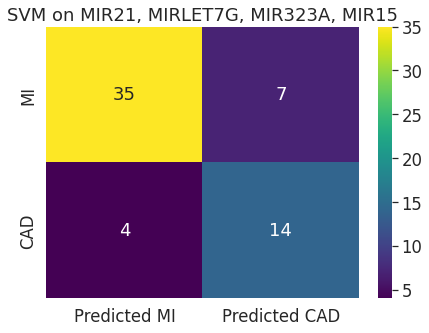

In [187]:
cm=confusion_matrix(y_test,pred,labels=['MI', 'CAD'])
df_cm=pd.DataFrame(cm,index=[i for i in ['MI', 'CAD']],columns=[i for i in ['Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('SVM on MIR21, MIRLET7G, MIR323A, MIR15')
sns.heatmap(df_cm,annot=True, cmap='viridis');

In [188]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         CAD       0.67      0.78      0.72        18
          MI       0.90      0.83      0.86        42

    accuracy                           0.82        60
   macro avg       0.78      0.81      0.79        60
weighted avg       0.83      0.82      0.82        60



In [189]:
label = LabelEncoder()

y_temp = label.fit_transform(df_resample['MI status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'MI']

n_classes = y_temp.shape[1]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=.25, random_state=27)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(C=1000, gamma=0.05, kernel='rbf', random_state=27))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


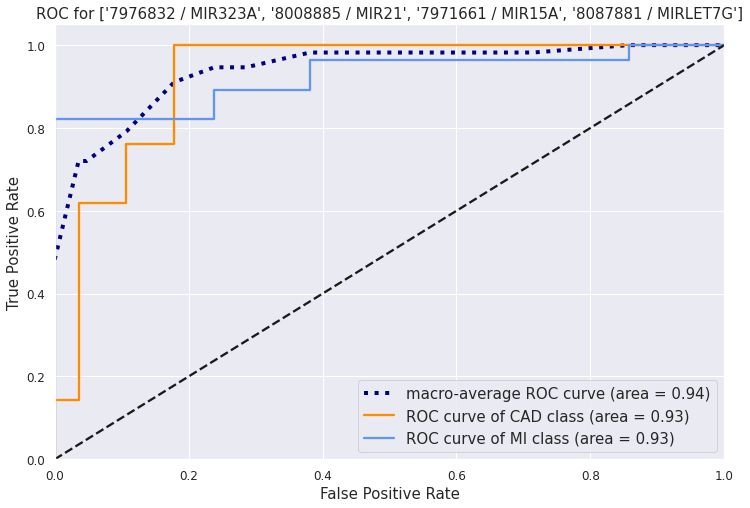

In [191]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_temp.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("323a, 21, 15A, let7g.pdf")